<span style="font-size:200%; text-align:left;"><b>Lab setup of long SRC in a Michelson</b></span>
<br/>
Code : Mostly D.Toyra but I, V Adya chipped in


# Importing packages

In [1]:
import pykat
import pykat.ifo as ifo
import pykat.ifo.aligo as aligo
import pykat.ifo.aligo.plot
from pykat.optics import ABCD as a

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

import pickle
import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset']=False


from scipy.optimize import minimize
from pykat.optics.gaussian_beams import BeamParam

                                              ..-
    PyKat develop         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



# Setting up Long SRC IFO
## Tuning DFO

In [ ]:
kat7 = pykat.finesse.kat()
kat7.verbose = False
kat7.load("LongSRC_design_24Sept.kat")
kat7.eom1.midx = 0


### Tuning Y arm

In [ ]:
kat = kat7.deepcopy()
kat.parse("""
xaxis EY phi lin -100 100 200
yaxis abs
""")
out = kat.run()
fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(111)
ax.plot(out.x, out['AS_Port'])
ax.set_xlim(out.x.min(),out.x.max())
ax.grid()
ax.set_title('Y-ARM')
ax.set_xlabel('Tuning [deg]')
ax.set_ylabel('Power [W]')
plt.show(fig)

In [ ]:
phi_Y = out.x[out['AS_Port'].argmin()]
print(phi_Y)

### X Arm

In [ ]:
#tuning x arm
kat = kat7.deepcopy()
kat.EY.phi = phi_Y

kat.parse("""
xaxis EX phi lin -100 100 200
yaxis abs
""")
out = kat.run()

fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(111)
ax.plot(out.x, out['AS_Port'])
ax.set_xlim(out.x.min(),out.x.max())
ax.grid()
ax.set_title('X-ARM')
ax.set_xlabel('Tuning [degb\]')
ax.set_ylabel('Power [W]')
plt.show(fig)

In [ ]:
phi_X = out.x[out['AS_Port'].argmin()]
phi_X

## Amplitude and phase of the carrier, sidebands everywhere


In [ ]:
kat6 = pykat.finesse.kat()
kat6.verbose = False
kat6.load("LongSRC_design_24Sept.kat")
kat6.EY.phi = phi_Y
kat6.EX.phi = phi_X


kat6.eom1.midx = 0.1


In [ ]:
# Tuning x arm
kat = kat6.deepcopy()

kat.parse("""
variable dummy 0
xaxis SRM phi lin -100 100 200
yaxis abs:deg
""")
out = kat.run()

fig = plt.figure(figsize=(7,9), dpi=100)
ax = fig.add_subplot(211)
ax1 = fig.add_subplot(212)

ax.plot(out.x, np.abs(out['Xarm']),label='Carrier, Xarm')
ax.plot(out.x, np.abs(out['Yarm']),label='Carrier, Yarm')
ax.plot(out.x, np.abs(out['SRCa']),label='Carrier, SRC')
ax.plot(out.x, np.abs(out['Xarm_f1']),label='SB, Xarm')
ax.plot(out.x, np.abs(out['Yarm_f1']),label='SB, Yarm')
ax.plot(out.x, np.abs(out['SRCa_f1']),label='SB, SRC')


ax1.plot(out.x, np.angle(out['Xarm']),label='Carrier, Xarm')
ax1.plot(out.x, np.angle(out['Yarm']),label='Carrier, Yarm')
ax1.plot(out.x, np.angle(out['SRCa']),label='Carrier, SRC')
ax1.plot(out.x, np.angle(out['Xarm_f1']),label='SB, Xarm')
ax1.plot(out.x, np.angle(out['Yarm_f1']),label='SB, Yarm')
ax1.plot(out.x, np.angle(out['SRCa_f1']),label='SB, SRC')

ax.set_xlim(out.x.min(),out.x.max())
ax.grid()
ax.set_title('Amplitude ')
ax.set_xlabel('SRC tuning [deg]')
ax.set_ylabel('au')
ax.legend()

ax1.set_xlim(out.x.min(),out.x.max())
ax1.grid()
ax1.set_title('Phase')
ax1.set_xlabel('SRC tuning [deg]')
ax1.set_ylabel('au')
ax1.legend()

plt.show(fig)

## Schnupp asymmetry optimisation

In [ ]:
#3.47256317425e-07
#Sidebands optimisation with Schnupp Asymmetry
kat1=kat6.deepcopy()
kat1.parse(""" 
ad SRC_SB1 1230000000 nSRM1
set test_sb1 SRC_SB1 abs
ad X_SB2 1230000000 nBS3
set test_sb2 X_SB2 abs
ad Y_SB3 1230000000 nBS2
set test_sb3 Y_SB3 abs
##########################################################################

func SRC_sb1 = $test_sb1 * $test_sb1
func X_sb2 = $test_sb2 * $test_sb2
func Y_sb3 = $test_sb3 * $test_sb3

variable schnupp_asym 0
xaxis schnupp_asym l lin 0 0.01 100
const lmean  1
func xlength = $lmean + 0.5*$x1
func ylength = $lmean - 0.5*$x1
put LX l $xlength
put LY l $ylength

noplot xlength
noplot ylength

""")


out1=kat1.run()
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax.semilogy(out1.x,np.abs(out1['SRC_sb1']),'b-',label='f1 in SRC')
ax.semilogy(out1.x,np.abs(out1['X_sb2']),'k-',label='f1 in X arm')
ax.semilogy(out1.x,np.abs(out1['Y_sb3']),'r-',label='f1 in Y arm')

ax.legend(loc=4)
ax.set_title('Sideband resonance conditions in the IFO ')
x=out1.x
#ax.set_xlim(x.min(),x.max())
#ax.set_ylim(0.000001,1)
ax.set_yscale("log")
ax.set_xlabel('Schnupp asymmetry [m]')
ax.set_ylabel('Sideband power in the SRC [W]')
ax.grid()

#print(out2['Y_sb3'])
#plt.savefig("SidebandCoupling.eps", bbox_inches='tight')

# Error signals

In [ ]:

#Adding photodoiodes to demodulate the output
kat6.parse(""" 
pd1 REFL_I 1230000000 10 nBS1
pd1 REFL_Q 1230000000 100 nBS1
pd1 DC_PD 0 0 nOut
pd1 TRANS_I 1230000000 0 nOut
pd1 TRANS_Q 1230000000 90 nOut

yaxis abs
""")

#Defining the different DoFs
LSCDOFs = ["SRCL","MICH"]
LSCDOFCommands = {}

LSCDOFCommands["MICH"] = """
variable dummy1 0
xaxis dummy1 phi lin -100 100 1000
put* EX phi $x1
put* EY phi $mx1
"""

LSCDOFCommands["SRCL"] = """
variable dummy5 0
xaxis dummy5 phi lin -100 100 1000
put* SRM phi $x1
"""


#Plot the Error signals and see if they make sense

for DOF in LSCDOFs:
    kat=kat6.deepcopy()
    kat.parse(LSCDOFCommands[DOF])
    out=kat.run()
    
    plt.figure()
    #plt.plot(out.x,out["DC_PD"], label="DC_PD")
    plt.plot(out.x,out["REFL_I"], label="Common_PD")
    plt.plot(out.x,out["REFL_Q"], label="SRCL_PD")
    #plt.plot(out.x,out["test_PD"], label="test_PD")
    #plt.plot(out.x,out["test_PD2"], label="test_PD")
    plt.legend()
    plt.grid()
    plt.ylabel("Signal [W]")
    plt.title(DOF)
    #plt.savefig(DOF+"1.jpg", bbox_inches='tight')
    plt.show()
   

# Test with long Signal Recycling Cavity
## Beam parameter testing

In [ ]:
kat2 = pykat.finesse.kat()
kat2.verbose = True
kat2.load("LongSRC_design_24Sept.kat")

kat2.parse("""
trace 10
mismatches

bp qx x q nBS4
bp qy x q nBS4

noxaxis
yaxis abs:deg
""")

kat2.removeBlock('Photodiodes')
kat2.EX.Rc = 30
kat2.EY.Rc = 30
kat2.SRM.Rc = np.inf


kat2.SRM_AR.Rc = 0.062997
kat2.SRCc2.L = 1.35e-01
kat2.SRC2.L = 1.1 - 1.35e-01 - 1e-2
#print(kat2.SRC2.L)
kat2.TSRM.Rc = 1.07
kat2.cTSRM.remove()

out2 = kat2.run()

print(out2.stdout)

qx = out2['qx']
qy = out2['qy']

#L1 = kat2.SRC1.L.value

In [ ]:
(0.106071314202909 + 0.0599822586338401j)*1.8

In [ ]:
qx

In [ ]:
kat2.generateKatScript()

## Some tips to run the  file if you happen to change parameters
1. If you change any lengths that matter, make sure the beam parameters used to calculate the RoC of SRM_AR and the distance between the AR surface and the first crystal surface is correct (Daniel has made it Vaishali proof but still no harm in checking)
2. Make sure to comment out the cav command for TSRM cavity and then look at the radius curvature of the wavefront at TSRM and use that value as the RoC of the TSRM.
3. Put in the cav command agian adn see if the waist in the crystal is correct i.e. 32 um in the middle of the crystal (5 mm)

# Printing cavity parameters and DC powers everywhere

In [ ]:
print("Input power",np.max(np.abs(out1['Pin'])))
print("Power going to x arm",np.max(np.abs(out1['Px'])))
print("Power going to y arm",np.max(np.abs(out1['Py'])))
print("Power in the SRC",np.max(np.abs(out1['Psrc'])))
print("DC Power on DARM PD",np.max(np.abs(out1['AS_Port'])))


# Some math to work out cavity parameters (No need to run!)

In [ ]:
m = -0.151429
(m+1.0)/2.0

In [ ]:
kat2.S

In [ ]:
L = 1.21

g1 = 1.0-L/30

g2 = 1.0-L/np.inf

print(g1)
print(g2)

print(g1*g2)

In [ ]:
R1 = 0.062997
L1 =  1.21


In [ ]:
g1 = 1.0-L1/R1

g2 = 1.0-L1/1.07



print(g1)
print(g2)

print(g1*g2)

# Learning how to use pykat ABCD matrices (NO need to run!)

In [ ]:
A = a.mirror_refl(1, 1)

q1 = pykat.optics.gaussian_beams.BeamParam(w0=1, z=0)

a.apply(A, q1, 1, 1)

In [ ]:
help(pykat.optics.gaussian_beams.BeamParam)

In [ ]:
help(a.space)
help(a.mirror_trans)

In [ ]:
q0 = pykat.optics.gaussian_beams.BeamParam(w0=315.781231594237e-6, z=460.760869565217e-3)

S0 = a.space(1,0.21)
S1 = a.mirror_trans(1, 1.45, 2.0)
S2 = a.space(1.45,0.006)
S3 = a.mirror_trans(1.45, 1, 0.025)
S4 = a.space(1,0.07)
S5 = a.mirror_trans(1, 1.8, np.inf)
S6 = a.space(1.8,0.005)

S7 = a.mirror_trans(1.8,1,np.inf)

Ssum = S6 * S5 * S4 * S3 * S2 * S1 * S0


q2 = a.apply(Ssum, q0, 1, 1.8)


In [ ]:
a.bs_trans(1.8,1, np.inf, np.inf, 1.14)

In [ ]:
q2

# Designing the waist size in the crystal  


## Controller

In [45]:
RoC_EX = 100
RoC_EY = 100

w_crys = 30e-6

## The model

In [46]:
base = pykat.finesse.kat()
base.verbose = True
base.load("LongSRC_design_24Sept.kat")

base.removeBlock('Photodiodes')

base.EX.Rc = RoC_EX
base.EY.Rc = RoC_EY

## Run 1
Running without `cav`-command on TSRM. Detecting complex beam parameter at output port of the beam splitter.

In [51]:
kat = base.deepcopy()
# Adding simulation instructions and detectors.
kat.parse("""

bp qex x q nEMx
bp qey x q nEMy

bp qbsx x q nBS4

cp cSRMX x m
cp cSRMY x m
cp cSRMX y m
cp cSRMY y m

noxaxis
yaxis abs:deg
""")

kat.cTSRM.remove()
                
out = kat.run()

#print(out2.stdout)

qBSx = out['qbsx']

qEXx = out['qex']
qEYx = out['qey']



# Checking stability
# --------------------
mX_x = np.abs(out['cSRMX_x_m'])
mY_x = np.abs(out['cSRMY_x_m'])
mX_y = np.abs(out['cSRMX_x_m'])
mY_y = np.abs(out['cSRMY_x_m'])

if (not (mX_x > -1 and mX_x < 1) or not (mX_y > -1 and mX_y < 1) or 
    not (mY_x > -1 and mY_x < 1) or not (mY_y > -1 and mY_y < 1)):
    print('Cavity is unstable!!!!! :(')
    print('Stability parameters: {}  {}  {}  {}'.format(mX_x, mY_x, mX_y, mY_y))
else:
    print('Cavity is stable! :) ')
    print('Stability parameters: {}  {}  {}  {}'.format(mX_x, mY_x, mX_y, mY_y))
# --------------------
  


--------------------------------------------------------------
Running kat - Started at 2019-09-30 17:36:55.199125

Finished in 0.0200748 seconds
Cavity is stable! :) 
Stability parameters: 0.9779  0.978  0.9779  0.978


100% | ETA:  0:00:00 | Calculating                                             

### Optimising SRM RoC2 and distance from crystal surface

In [52]:

# q0 = pykat.optics.gaussian_beams.BeamParam(w0=315.781231594237e-6, z=460.76086956521e-3)

q0 = BeamParam(q=qBSx) # Here we import the beam parameter from nBS4 which is 
                     # the node of the BS facing the HR surface of SRM

# Define the function here and the parameters to vary are 
# RoC of the AR surface of SRM (roc in the functions below) and the distance between
# crystal and the AR surface of SRM (L in the functions below)

# Here we have used the pykat ABCD matrices which account for refractive index in beam parameter
# Unlike the wikipedia ABCD matrices which have the beam parameter included in the matrix element
# so tl:dr be careful when comparing things
# The function rocL calculates the beam parameters and we have this here
# to make sure we get a waist at the centre of the crystal

def rocL(roc, L):
    S0 = a.space(1,kat.SRC1.L.value)
    S1 = a.mirror_trans(1, kat.thsrm1.n.value, np.inf)
    S2 = a.space(kat.thsrm1.n.value, kat.thsrm1.L.value)
    S3 = a.mirror_trans(kat.thsrm1.n.value, 1, roc)
    S4 = a.space(1, L)
    S5 = a.mirror_trans(1, kat.sCRYS.n.value, np.inf) 
    S6 = a.space(kat.sCRYS.n.value, kat.sCRYS.L.value/2.0)

    Ssum = S6 * S5 * S4 * S3 * S2 * S1 * S0

    return a.apply(Ssum, q0, 1, 1.8)

# Here we define a function to vary the L and roc
def fun2(L, roc):
    if L <=0:   # Adding this here to make sure that the minimisation routine does not spit out negative values of L for me
        return 1000
    return np.abs(rocL(roc, L).z)
    
def fun1(diopt):
    
    sol = minimize(fun2, 0.07, args=(1/diopt), method='Nelder-Mead') # Minimisation routine to find the best roc and L 
    
    L = sol.x[0]
    q = rocL(1.0/diopt, L)
    z = q.z
    w0 = q.w0
    return np.abs(w0-w_crys)

# Optimising RoC
sol1 = minimize(fun1, 1.0/0.062997, method='Nelder-Mead') # Minimisation routine to find the best roc and L 
RoC_SRMAR = 1.0/sol1.x

# Finding correspoinding length
sol2 = minimize(fun2, 0.07, args=RoC_SRMAR, method='Nelder-Mead') # Minimisation routine to find the best roc and L 
L = sol2.x
print(RoC_SRMAR, L)

[0.07634193] [0.16367969]


## Run 2
Obtaining the RoC of the beam front at the TSRM

In [53]:
kat = base.deepcopy()

# Setting values as optimsised above
kat.SRM_AR.Rc = RoC_SRMAR
kat.SRCc2.L = L

L_SRC = (kat.LX.L.value+kat.LY.L.value)/2.0 + kat.SRC1.L.value
L_SRC2 = L_SRC - (kat.thsrm1.L.value*kat.thsrm1.n.value + L + kat.sCRYS.L.value*kat.sCRYS.n.value)
# Setting distance between crystal and TSRM such that the total length of the TSRC matches the SRC length.
kat.SRC2.L = L_SRC2

kat.parse("""
bp Rcx_tsrm x r nTSRM1
bp Rcy_tsrm y r nTSRM1

noxaxis
yaxis abs
""")
kat.cTSRM.remove()

out = kat.run()

Rcx = out['Rcx_tsrm']
Rcy = out['Rcy_tsrm']
# Average beam front radius
Rc = (Rcx + Rcy)/2.0
print(Rcx, Rcy, Rc)

--------------------------------------------------------------
Running kat - Started at 2019-09-30 17:36:56.881698

Finished in 0.0205309 seconds
0.914847516820705 0.914849990121275 0.9148487534709899


100% | ETA:  0:00:00 | Calculating                                             

## Run 3
Check modematching

In [54]:
kat = base.deepcopy()

# Setting values as optimsised above
kat.SRM_AR.Rc = RoC_SRMAR
kat.SRCc2.L = L
kat.TSRM.Rc = Rc
kat.SRC2.L = L_SRC2


kat.parse("""
bp Rcx_tsrm x r nTSRM1
bp Rcy_tsrm y r nTSRM1
mismatches
noxaxis
""")

out = kat.run()
print(out.stdout)

Parsing `mismatches` into pykat object not implemented yet, added as extra line.
--------------------------------------------------------------
Running kat - Started at 2019-09-30 17:36:57.727554

Finished in 0.0213361 seconds

------------------------------------------------------------------------
                     FINESSE 2.2                (build 2.2-31-ge1141681)
       o_.-=.        Frequency domain INterferomEter Simulation SoftwarE
      (\'".\|        06.03.2019         http://www.gwoptics.org/finesse/
      .>' (_--.      
   _=/d   ,^\        Input file /var/folders/k1/yts33d_93v1_9yd1768nkwph0000gn/T/tmpgtixpkbk.kat,
  ~~ \)-'   '        Output file /var/folders/k1/yts33d_93v1_9yd1768nkwph0000gn/T/tmpgtixpkbk.out,
     / |             Gnuplot file /var/folders/k1/yts33d_93v1_9yd1768nkwph0000gn/T/tmpgtixpkbk.gnu 
    '  '                                        Mon Sep 30 17:36:57 2019
------------------------------------------------------------------------
 'noxaxis' has 

100% | ETA:  0:00:00 | Calculating                                             

If all looks good, setting parameters to `base`.

In [55]:
base.SRM_AR.Rc = RoC_SRMAR
base.SRCc2.L = L
base.TSRM.Rc = Rc
base.SRC2.L = L_SRC2

## Plot beam sizes

In [62]:
kat = base.deepcopy()

kat.parse("""

bp qex x q nEMx
bp qbsx x q nBS4
bp qsrm x q nSRM1
bp qsrmarx x q nSRM_AR2
bp qcr1 x q nCRYS1a
bp q_cr1b x q nCRYS1b
bp qcr2 x q nCRYS2b
bp qtsrm x q nTSRM1


cp cSRMX x m
cp cSRMY x m
cp cSRMX y m
cp cSRMY y m

cp cTSRM x m
cp cTSRM y m

noxaxis
yaxis abs:deg
""")

                
out = kat.run()


qex = out['qex']

qbsx = out['qbsx']
qsrm = out['qsrm']

qsrmarx = out['qsrmarx']
qcr1 = out['qcr1']
qcr2 = out['qcr2']
qtsrm = out['qtsrm']

mX_x = np.abs(out['cSRMX_x_m'])
mY_x = np.abs(out['cSRMY_x_m'])
mX_y = np.abs(out['cSRMX_x_m'])
mY_y = np.abs(out['cSRMY_x_m'])

mTSRM_x = np.abs(out['cTSRM_x_m'])
mTSRM_y = np.abs(out['cTSRM_y_m'])


if (not (mX_x > -1 and mX_x < 1) or not (mX_y > -1 and mX_y < 1) or 
    not (mY_x > -1 and mY_x < 1) or not (mY_y > -1 and mY_y < 1) or 
    not (mTSRM_x > -1 and mTSRM_x < 1) or not (mTSRM_y > -1 and mTSRM_y < 1)):
    print('Cavity is unstable! :) ')
    print('Stability parameters: {}  {}  {}  {}  {}  {}'.format(mX_x, mY_x, mX_y, mY_y, mTSRM_x, mTSRM_y))
else:
    print('Cavity is stable! :) ')
    print('Stability parameters: {}  {}  {}  {}  {}  {}'.format(mX_x, mY_x, mX_y, mY_y, mTSRM_x, mTSRM_y))

--------------------------------------------------------------
Running kat - Started at 2019-09-30 17:40:25.818390

Finished in 0.0212338 seconds
Cavity is stable! :) 
Stability parameters: 0.9779  0.978  0.9779  0.978  0.999300593938465  0.999334795323018


100% | ETA:  0:00:00 | Calculating                                             

In [59]:
mTSRM_x

0.999300593938465

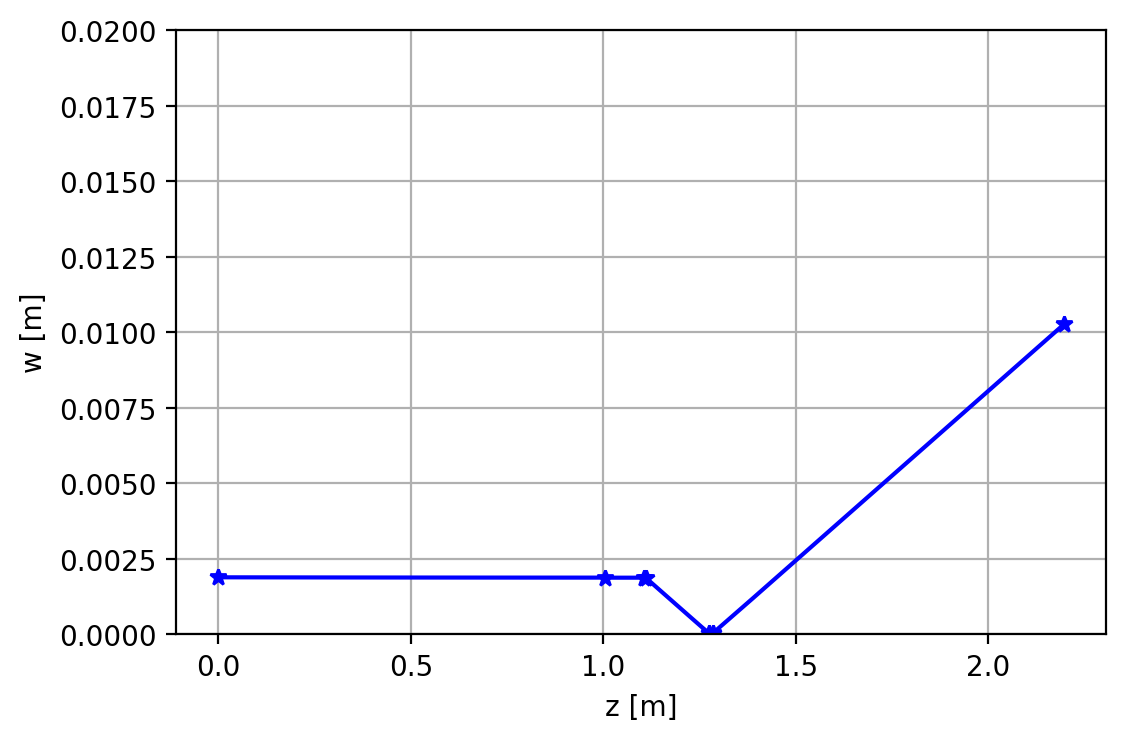

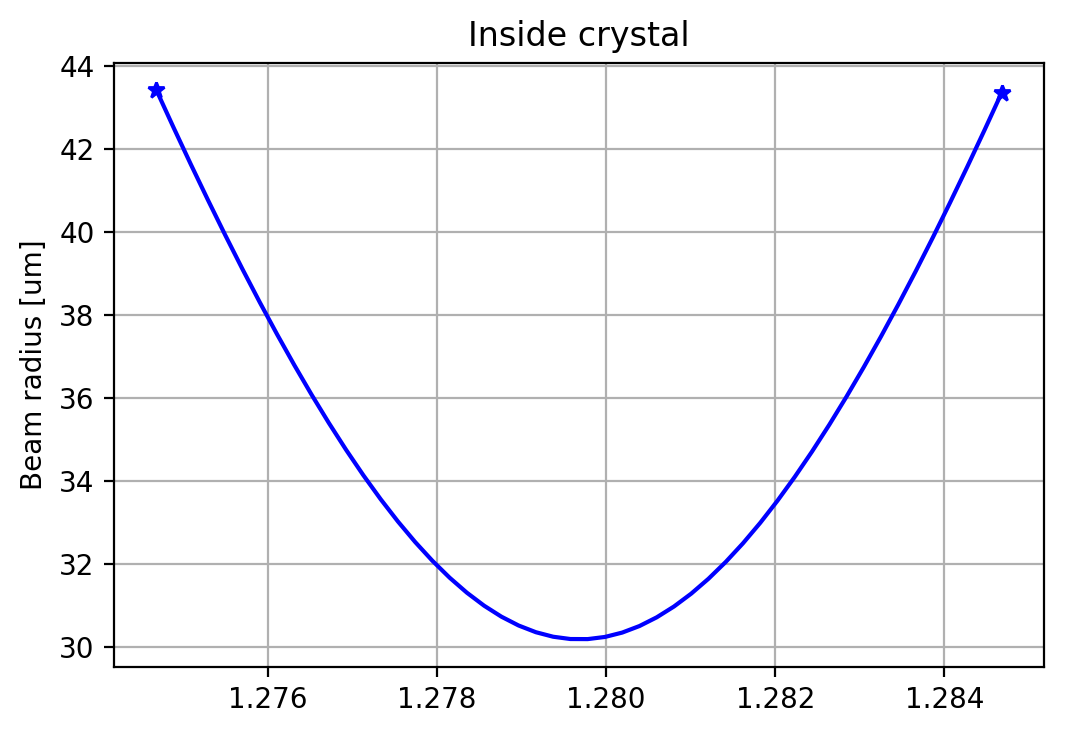

In [57]:
def q2w(q0,z,n=1):
    w = np.zeros(len(z))
    for k,a in enumerate(z):
        w[k] = BeamParam(q=q0+a, nr=n).w
    return w



###############################################
# Lengths and parameters
###############################################


# End mirror
w_ex = BeamParam(q=qex).w

# End mirror to BS
L_ex_bs = kat.LX.L.value
z_ex_bs = np.linspace(0,L_ex_bs,10)
w_ex_bs = q2w(qex, z_ex_bs)

# BS
w_bs = BeamParam(q=qbsx).w

# BS to SRM
L_bs_srm = kat.SRC1.L.value
z_bs_srm = np.linspace(0,L_bs_srm,10)
w_bs_srm = q2w(qbsx,z_bs_srm)
z_bs_srm += L_ex_bs

# SRM
w_srm = BeamParam(q=qsrm).w

# SRM substrate
L_srm_sub = kat.thsrm1.L.value

# SRM AR
w_srmar = BeamParam(q=qsrmarx).w

# SRM AR to Crystal
L_srm_crys = kat.SRCc2.L.value
z_srm_crys = np.linspace(0,L_srm_crys,10)
w_srm_crys = q2w(qsrmarx, z_srm_crys)
z_srm_crys += L_ex_bs+L_bs_srm+L_srm_sub

# Crystal, surface 1
w_crys = BeamParam(q=qcr1).w

# Inside the Crystal
L_crys = kat.sCRYS.L.value
z_crys_sub = np.linspace(0,L_crys,50)
w_crys_sub = q2w(qcr1*kat.sCRYS.n.value, z_crys_sub, n=kat.sCRYS.n.value)
z_crys_sub += L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys


# Crystal, surface 2
w_crys2 = BeamParam(q=qcr2).w

# Crystal to TSRM
L_crys_tsrm = kat.SRC2.L.value
z_crys_tsrm = np.linspace(0,L_crys_tsrm,10)
w_crys_tsrm = q2w(qcr2,z_crys_tsrm)
z_crys_tsrm += L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys

# TSRM
w_tsrm = BeamParam(q=qtsrm).w


###############################################
# Plotting
###############################################

fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)

# End mirror
ax.plot(0,w_ex,'b*')
ax.plot(0,-w_ex,'b*')

# End mirror to BS
ax.plot(z_ex_bs, w_ex_bs,'-b')
ax.plot(z_ex_bs, -w_ex_bs,'-b')

# BS
ax.plot(L_ex_bs, w_bs,'b*')
ax.plot(L_ex_bs, -w_bs,'b*')

# BS to SRM
ax.plot(z_bs_srm, w_bs_srm,'-b')
ax.plot(z_bs_srm, -w_bs_srm,'-b')

# SRM
ax.plot(L_ex_bs+L_bs_srm,w_srm,'b*')
ax.plot(L_ex_bs+L_bs_srm,-w_srm,'b*')

# SRMAR
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub,w_srmar,'b*')
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub,-w_srmar,'b*')

# SRMAR to Crystal
ax.plot(z_srm_crys, w_srm_crys,'-b')
ax.plot(z_srm_crys, -w_srm_crys,'-b')

# Crystal surface 1
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys, w_crys,'b*')
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys, -w_crys,'b*')

# Inside Crystal
ax.plot(z_crys_sub, w_crys_sub,'-b')
ax.plot(z_crys_sub, -w_crys_sub,'-b')

# Crystal surface 2
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys, w_crys2,'b*')
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys, -w_crys2,'b*')

# Crystal to TSRM
ax.plot(z_crys_tsrm, w_crys_tsrm,'-b')
ax.plot(z_crys_tsrm, -w_crys_tsrm,'-b')

# TSRM
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys+L_crys_tsrm, w_tsrm,'b*')
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys+L_crys_tsrm, -w_tsrm,'b*')

ax.set_ylabel('w [m]')
ax.set_xlabel('z [m]')

ax.grid()
ax.set_ylim(0,0.02)
plt.show(fig)



fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)

# Crystal surface 1
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys, w_crys*1e6,'b*')
#ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys, -w_crys,'b*')

# Inside Crystal
ax.plot(z_crys_sub, w_crys_sub*1e6,'-b')
#ax.plot(z_crys_sub, -w_crys_sub,'-b')

# Crystal surface 2
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys, w_crys2*1e6,'b*')
#ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys, -w_crys2,'b*')
ax.grid()

ax.set_ylabel('Beam radius [um]')
ax.set_title('Inside crystal')
plt.show(fig)

In [ ]:
out2['cSRMX_x_m']

In [ ]:
out2.ylabels

In [ ]:
kat2.cSRM

In [ ]:
qcr1

In [ ]:
BeamParamqex

In [ ]:
help(BeamParam)

## Plot beam

In [ ]:
def q2w(q0,z,n=1):
    w = np.zeros(len(z))
    for k,a in enumerate(z):
        w[k] = BeamParam(q=q0+a, nr=n).w
    return w



###############################################
# Lengths and parameters
###############################################


# End mirror
w_ex = BeamParam(q=qex).w

# End mirror to BS
L_ex_bs = kat2.LX.L.value
z_ex_bs = np.linspace(0,L_ex_bs,10)
w_ex_bs = q2w(qex, z_ex_bs)

# BS
w_bs = BeamParam(q=qbsx).w

# BS to SRM
L_bs_srm = kat2.SRC1.L.value
z_bs_srm = np.linspace(0,L_bs_srm,10)
w_bs_srm = q2w(qbsx,z_bs_srm)
z_bs_srm += L_ex_bs

# SRM
w_srm = BeamParam(q=qsrm).w

# SRM substrate
L_srm_sub = kat2.thsrm1.L.value

# SRM AR
w_srmar = BeamParam(q=qsrmarx).w

# SRM AR to Crystal
L_srm_crys = kat2.SRCc2.L.value
z_srm_crys = np.linspace(0,L_srm_crys,10)
w_srm_crys = q2w(qsrmarx, z_srm_crys)
z_srm_crys += L_ex_bs+L_bs_srm+L_srm_sub

# Crystal, surface 1
w_crys = BeamParam(q=qcr1).w

# Inside the Crystal
L_crys = kat2.sCRYS.L.value
z_crys_sub = np.linspace(0,L_crys,10)
w_crys_sub = q2w(qcr1*kat2.sCRYS.n.value, z_crys_sub, n=kat2.sCRYS.n.value)
z_crys_sub += L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys


# Crystal, surface 2
w_crys2 = BeamParam(q=qcr2).w

# Crystal to TSRM
L_crys_tsrm = kat2.SRC2.L.value
z_crys_tsrm = np.linspace(0,L_crys_tsrm,10)
w_crys_tsrm = q2w(qcr2,z_crys_tsrm)
z_crys_tsrm += L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys

# TSRM
w_tsrm = BeamParam(q=qtsrm).w


###############################################
# Plotting
###############################################

fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)

# End mirror
ax.plot(0,w_ex,'b*')
ax.plot(0,-w_ex,'b*')

# End mirror to BS
ax.plot(z_ex_bs, w_ex_bs,'-b')
ax.plot(z_ex_bs, -w_ex_bs,'-b')

# BS
ax.plot(L_ex_bs, w_bs,'b*')
ax.plot(L_ex_bs, -w_bs,'b*')

# BS to SRM
ax.plot(z_bs_srm, w_bs_srm,'-b')
ax.plot(z_bs_srm, -w_bs_srm,'-b')

# SRM
ax.plot(L_ex_bs+L_bs_srm,w_srm,'b*')
ax.plot(L_ex_bs+L_bs_srm,-w_srm,'b*')

# SRMAR
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub,w_srmar,'b*')
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub,-w_srmar,'b*')

# SRMAR to Crystal
ax.plot(z_srm_crys, w_srm_crys,'-b')
ax.plot(z_srm_crys, -w_srm_crys,'-b')

# Crystal surface 1
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys, w_crys,'b*')
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys, -w_crys,'b*')

# Inside Crystal
ax.plot(z_crys_sub, w_crys_sub,'-b')
ax.plot(z_crys_sub, -w_crys_sub,'-b')

# Crystal surface 2
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys, w_crys2,'b*')
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys, -w_crys2,'b*')

# Crystal to TSRM
ax.plot(z_crys_tsrm, w_crys_tsrm,'-b')
ax.plot(z_crys_tsrm, -w_crys_tsrm,'-b')

# TSRM
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys+L_crys_tsrm, w_tsrm,'b*')
ax.plot(L_ex_bs+L_bs_srm+L_srm_sub+L_srm_crys+L_crys+L_crys_tsrm, -w_tsrm,'b*')

ax.set_ylabel('w [m]')
ax.set_xlabel('z [m]')

plt.show(fig)

In [ ]:
kat2.sCRYS.n.value

In [ ]:
w_crys_sub

In [ ]:
w_crys2

In [ ]:
40.9584826219816

In [ ]:
w_crys2

In [ ]:
qcr1*1.8

In [65]:
kat2.SRM.Rc

<AttrParam (SRM.Rcx=inf) at 0x181779ca90>

In [ ]:
BeamParam(q=out2['q_cr1b'],nr=1.8).w

In [ ]:


q_etm = out['qx_ex']




zs = np.linspace(-10,10,100)
w = np.zeros(len(zs))
for k,z in enumerate(zs):
    w[k] = (q0+z).w
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(zs,w)
ax.plot(zs,-w)
ax.set_ylabel('w [m]')
ax.set_xlabel('z [m]')

plt.show(fig)

# Playground

In [15]:
# q0 = pykat.optics.gaussian_beams.BeamParam(w0=315.781231594237e-6, z=460.76086956521e-3)

q0 = BeamParam(q=qBSx) # Here we import the beam parameter from nBS4 which is 
                     # the node of the BS facing the HR surface of SRM

# Define the function here and the parameters to vary are 
# RoC of the AR surface of SRM (roc in the functions below) and the distance between
# crystal and the AR surface of SRM (L in the functions below)

# Here we have used the pykat ABCD matrices which account for refractive index in beam parameter
# Unlike the wikipedia ABCD matrices which have the beam parameter included in the matrix element
# so tl:dr be careful when comparing things
# The function rocL calculates the beam parameters and we have this here
# to make sure we get a waist at the centre of the crystal

def rocL(roc, L):
    S0 = a.space(1,kat.SRC1.L.value)
    S1 = a.mirror_trans(1, kat.thsrm1.n.value, np.inf)
    S2 = a.space(kat.thsrm1.n.value, kat.thsrm1.L.value)
    S3 = a.mirror_trans(kat.thsrm1.n.value, 1, roc)
    S4 = a.space(1, L)
    S5 = a.mirror_trans(1, kat.sCRYS.n.value, np.inf) 
    S6 = a.space(kat.sCRYS.n.value, kat.sCRYS.L.value/2.0)

    Ssum = S6 * S5 * S4 * S3 * S2 * S1 * S0

    return a.apply(Ssum, q0, 1, 1.8)

# Here we define a function to vary the L and roc
def fun2(L, roc):
    if L <=0:   # Adding this here to make sure that the minimisation routine does not spit out negative values of L for me
        return 1000
    return np.abs(rocL(roc, L).z)
    

diopt = np.linspace(0.1, 100, 20) #Dioptres is used because - just easier to do. We have gone from 1 cm RoC to 10 m RoC

for k,d in enumerate(diopt):
    
    sol = minimize(f, 0.07, args=(1/d), method='Nelder-Mead', tol=1e-6) # Minimisation routine to find the best roc and L 
    
    L = sol.x[0]
    q = rocL(1.0/d, L)
    z = q.z
    w0 = q.w0
    
    print('RoC = {:10.6f} m ---> L = {:.2e} m, where z = {:9.2e} m, w0 = {:.3f} mm'.format(1.0/d, L, z, w0*1e3))

RoC =  10.000000 m ---> L = 1.36e+00 m, where z = -1.33e-07 m, w0 = 1.338 mm
RoC =   0.186640 m ---> L = 4.02e-01 m, where z =  1.21e-08 m, w0 = 0.100 mm
RoC =   0.094199 m ---> L = 2.02e-01 m, where z = -2.74e-07 m, w0 = 0.050 mm
RoC =   0.062997 m ---> L = 1.35e-01 m, where z = -7.32e-07 m, w0 = 0.034 mm
RoC =   0.047323 m ---> L = 1.00e-01 m, where z = -7.28e-07 m, w0 = 0.025 mm
RoC =   0.037894 m ---> L = 7.99e-02 m, where z =  4.65e-07 m, w0 = 0.020 mm
RoC =   0.031598 m ---> L = 6.61e-02 m, where z =  2.40e-07 m, w0 = 0.017 mm
RoC =   0.027096 m ---> L = 5.63e-02 m, where z =  5.93e-07 m, w0 = 0.014 mm
RoC =   0.023717 m ---> L = 4.89e-02 m, where z = -4.81e-07 m, w0 = 0.013 mm
RoC =   0.021088 m ---> L = 4.32e-02 m, where z =  5.92e-07 m, w0 = 0.011 mm
RoC =   0.018983 m ---> L = 3.86e-02 m, where z = -4.21e-07 m, w0 = 0.010 mm
RoC =   0.017260 m ---> L = 3.49e-02 m, where z =  4.39e-07 m, w0 = 0.009 mm
RoC =   0.015824 m ---> L = 3.17e-02 m, where z =  5.09e-07 m, w0 = 0.008 mm